In [18]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
from transformers import Trainer, TrainingArguments
from peft import LoraConfig, get_peft_model, PromptTuningConfig, PeftType
from transformers import AutoModel, AutoTokenizer
# 使用本地路径加载模型和分词器
model_path = "model/qwen0.5b"
# 使用AutoModel来加载Qwen模型
# AutoModel 是用于加载 Transformer 模型的通用接口，这里加载的是 Qwen-0.5B 模型
model = AutoModel.from_pretrained(model_path)
# 使用AutoTokenizer来加载分词器
# AutoTokenizer 是用于处理文本输入的工具，它负责将文本转换为模型可以处理的张量格式
tokenizer = AutoTokenizer.from_pretrained(model_path)
# 测试分词器
text = "我喜欢小狗"  # 输入的示例文本
# 将文本转换为模型输入格式（张量），包括词汇的编码和注意力掩码
inputs = tokenizer(text, return_tensors="pt")
# 使用模型进行推理，生成输出，将张量输入到模型，得到输出，包括 last_hidden_state 和 past_key_values
outputs = model(input_ids=inputs['input_ids'], attention_mask=inputs['attention_mask'])
# 输出模型的返回结果，包括隐藏状态和缓存的上下文信息
#print(outputs)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [16]:
from transformers import AutoTokenizer

model_path = "model/qwen0.5b"

try:
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    print("Tokenizer loaded successfully.")
except Exception as e:
    print(f"Error loading tokenizer: {e}")


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Tokenizer loaded successfully.


In [20]:
import json
from torch.utils.data import Dataset, DataLoader

# 读取自定义的JSON格式问答数据集
with open('./data/SQuAD1.1/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 定义自定义数据集类
class QADataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        inputs = self.tokenizer(sample["context"], sample["question"], return_tensors="pt", padding="max_length", truncation=True)
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": self.tokenizer(sample["answer"], return_tensors="pt")["input_ids"].squeeze()
        }

# 加载数据集
dataset = QADataset(data, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 查看前两个样本
print(data[:2])


[{'id': 0, 'answer': 'Saint Bernadette Soubirous', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'context': 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.', 'p_phrase': ['Lourdes', 'France', '1858', 'the Virgin Mary', 'appeared'], 'n_phrase': ['Saint Bernadette Soubirous'], 'full answer': 'The Virgin Mary allegedly appeared in 1858 in Lourdes France to Saint Bernadette Soubirous.'}, {'id': 1, 'answer': 'a copper statue of Christ', 'question': 'What is in front of the Notre Dame Main Building?', 'context': 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".', 'p_phrase': ['the Main Building', 'Christ', 'front'], 'n_phrase': ['a copper statue', 'facing'], 'full answer': 'A copper statue of Christ is in front of the Notre Dame Main Building.'}]


In [21]:
from transformers import AutoModelForCausalLM
import torch

# 加载Qwen模型
model_path = "./model/qwen0.5b"
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype="auto", device_map="auto")

# 打印模型的原始结构
print("微调前的模型结构:")
print(model)

# 打印所有可训练参数
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"微调前: 可训练参数: {trainable_params} / 总参数: {all_params}")
    
print_trainable_parameters(model)


微调前的模型结构:
Qwen2ForCausalLM(
  (model): Qwen2Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-23): 24 x Qwen2DecoderLayer(
        (self_attn): Qwen2SdpaAttention(
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (o_proj): Linear(in_features=1024, out_features=1024, bias=False)
          (rotary_emb): Qwen2RotaryEmbedding()
        )
        (mlp): Qwen2MLP(
          (gate_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (up_proj): Linear(in_features=1024, out_features=2816, bias=False)
          (down_proj): Linear(in_features=2816, out_features=1024, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): Qwen2RMSNorm()
        (post_attention_layernorm): Qwen2RMSNorm()
      )
    )
    (norm): Qwen2RMSNorm()
  )
  (lm_h

In [22]:
from peft import LoraConfig, get_peft_model, TaskType

# 设置LoRA配置
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,   # 语言模型任务
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # 插入LoRA的模块
    inference_mode=False,   # 非推理模式，用于训练
    r=8,   # 降维矩阵秩
    lora_alpha=32,  # LoRA缩放因子
    lora_dropout=0.1  # Dropout率
)

# 应用LoRA到模型
model = get_peft_model(model, peft_config)

# 打印应用LoRA后的模型结构
print("\n微调后的模型结构:")
print(model)

# 打印应用LoRA后可训练的参数
print_trainable_parameters(model)



微调后的模型结构:
PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1024)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_f

In [23]:
from transformers import AutoModelForCausalLM, AutoTokenizer
from peft import LoraConfig, get_peft_model, TaskType
import torch

# 加载Qwen模型
model_path = "./model/qwen0.5b"
model = AutoModelForCausalLM.from_pretrained(model_path, torch_dtype="auto", device_map="auto")
tokenizer = AutoTokenizer.from_pretrained(model_path)

# 设置LoRA配置
peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,   # 语言模型任务
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],  # 指定需要插入LoRA的模块
    inference_mode=False,   # 非推理模式，用于训练
    r=8,   # 降维后矩阵的秩
    lora_alpha=32,  # LoRA缩放因子
    lora_dropout=0.1  # Dropout率
)

# 将LoRA配置应用于模型
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# 将模型移动到GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


trainable params: 3,784,704 || all params: 467,772,416 || trainable%: 0.8091


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2ForCausalLM(
      (model): Qwen2Model(
        (embed_tokens): Embedding(151936, 1024)
        (layers): ModuleList(
          (0-23): 24 x Qwen2DecoderLayer(
            (self_attn): Qwen2SdpaAttention(
              (q_proj): lora.Linear(
                (base_layer): Linear(in_features=1024, out_features=1024, bias=True)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=1024, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=1024, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear(
                (base_layer): Linear(in_features=102

In [24]:
import json
from torch.utils.data import Dataset, DataLoader

# 读取自定义的JSON格式问答数据集
with open('./data/SQuAD1.1/train.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# 定义自定义数据集类
class QADataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        inputs = self.tokenizer(sample["context"], sample["question"], return_tensors="pt", padding="max_length", truncation=True)
        return {
            "input_ids": inputs["input_ids"].squeeze(),
            "attention_mask": inputs["attention_mask"].squeeze(),
            "labels": self.tokenizer(sample["answer"], return_tensors="pt")["input_ids"].squeeze()
        }

# 加载数据集
dataset = QADataset(data, tokenizer)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 查看前两个样本
print(data[:2])


[{'id': 0, 'answer': 'Saint Bernadette Soubirous', 'question': 'To whom did the Virgin Mary allegedly appear in 1858 in Lourdes France?', 'context': 'It is a replica of the grotto at Lourdes, France where the Virgin Mary reputedly appeared to Saint Bernadette Soubirous in 1858.', 'p_phrase': ['Lourdes', 'France', '1858', 'the Virgin Mary', 'appeared'], 'n_phrase': ['Saint Bernadette Soubirous'], 'full answer': 'The Virgin Mary allegedly appeared in 1858 in Lourdes France to Saint Bernadette Soubirous.'}, {'id': 1, 'answer': 'a copper statue of Christ', 'question': 'What is in front of the Notre Dame Main Building?', 'context': 'Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend "Venite Ad Me Omnes".', 'p_phrase': ['the Main Building', 'Christ', 'front'], 'n_phrase': ['a copper statue', 'facing'], 'full answer': 'A copper statue of Christ is in front of the Notre Dame Main Building.'}]


In [25]:
from transformers import AutoTokenizer
from torch.utils.data import Dataset, DataLoader
import torch
import json
import numpy as np

class QADataset(Dataset):
    def __init__(self, data_path, tokenizer, max_source_length, max_target_length) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.max_seq_length = self.max_source_length + self.max_target_length

        self.data = []
        if data_path:
            with open(data_path, "r", encoding='utf-8') as f:
                self.data = json.load(f)  # 直接加载整个文件内容
                print("Data loaded, size:", len(self.data))

    def preprocess(self, question, answer, context):
        # 如果没有 apply_chat_template 方法，可以直接用 tokenizer
        instruction = self.tokenizer(question, add_special_tokens=False, max_length=self.max_source_length)
        response = self.tokenizer(answer, add_special_tokens=False, max_length=self.max_target_length)
        
        # 根据上下文添加内容
        context_ids = self.tokenizer(context, add_special_tokens=False)["input_ids"]
        
        input_ids = context_ids + instruction["input_ids"] + response["input_ids"] + [self.tokenizer.pad_token_id]
        attention_mask = ([1] * len(context_ids) + 
                          instruction["attention_mask"] + 
                          response["attention_mask"] + 
                          [1])
        
        labels = [-100] * (len(context_ids) + len(instruction["input_ids"])) + response["input_ids"] + [self.tokenizer.pad_token_id]
        
        if len(input_ids) > self.max_seq_length:
            input_ids = input_ids[:self.max_seq_length]
            attention_mask = attention_mask[:self.max_seq_length]
            labels = labels[:self.max_seq_length]
        
        return input_ids, attention_mask, labels

    def __getitem__(self, index):
        item_data = self.data[index]
        
        input_ids, attention_mask, labels = self.preprocess(
            question=item_data["question"],
            answer=item_data["answer"],
            context=item_data["context"]
        )

        return {
            "input_ids": torch.LongTensor(np.array(input_ids)),
            "attention_mask": torch.LongTensor(np.array(attention_mask)),
            "labels": torch.LongTensor(np.array(labels))
        }

    def __len__(self):
        return len(self.data)

# 确保 tokenizer 正确初始化
tokenizer = AutoTokenizer.from_pretrained("./model/qwen0.5b")

# 创建数据集
dataset = QADataset(data_path='./data/SQuAD1.1/train.json', tokenizer=tokenizer, max_source_length=256, max_target_length=128)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

# 查看前两个样本
for i in range(2):
    print(dataset[i])


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Data loaded, size: 86635
{'input_ids': tensor([  2132,    374,    264,  36954,    315,    279,    342,   4640,    983,
           518,    444,    413,   5799,     11,   9625,   1380,    279,  11214,
         10244,  91972,    398,   9723,    311,  14205,  14168,    329,   6535,
           328,   5482,    404,    782,    304,    220,     16,     23,     20,
            23,     13,   1249,   8711,   1521,    279,  11214,  10244,  19204,
          4994,    304,    220,     16,     23,     20,     23,    304,    444,
           413,   5799,   9625,     30,  56375,  14168,    329,   6535,    328,
          5482,    404,    782, 151643]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'labels': tensor([  -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,   -100,
          -100,   -100, 

In [26]:
# -*- coding: utf-8 -*-
from torch.utils.data import Dataset
import torch
import json
import numpy as np


class QADataset(Dataset):
    def __init__(self, data_path, tokenizer, max_source_length, max_target_length) -> None:
        super().__init__()
        self.tokenizer = tokenizer
        self.max_source_length = max_source_length
        self.max_target_length = max_target_length
        self.max_seq_length = self.max_source_length + self.max_target_length

        self.data = []
        if data_path:
            with open(data_path, "r", encoding='utf-8') as f:
                self.data = json.load(f)  # 直接读取JSON文件
        print("data load, size:", len(self.data))

    def preprocess(self, question, answer):
        messages = [
            {"role": "system", "content": "你是一个英语问答系统，可以根据用户的问题进行解答。"},
            {"role": "user", "content": question}
        ]
        prompt = self.tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        instruction = self.tokenizer(prompt, add_special_tokens=False, max_length=self.max_source_length)
        response = self.tokenizer(answer, add_special_tokens=False, max_length=self.max_target_length)
        
        input_ids = instruction["input_ids"] + response["input_ids"] + [self.tokenizer.pad_token_id]
        attention_mask = (instruction["attention_mask"] + response["attention_mask"] + [1])
        labels = [-100] * len(instruction["input_ids"]) + response["input_ids"] + [self.tokenizer.pad_token_id]

        # 确保输入长度不超过最大序列长度
        if len(input_ids) > self.max_seq_length:
            input_ids = input_ids[:self.max_seq_length]
            attention_mask = attention_mask[:self.max_seq_length]
            labels = labels[:self.max_seq_length]

        return input_ids, attention_mask, labels

    def __getitem__(self, index):
        item_data = self.data[index]

        # 获取问题和答案
        question = item_data['question']
        answer = item_data['answer']

        input_ids, attention_mask, labels = self.preprocess(question, answer)

        # 进行填充以确保张量大小一致
        input_ids = torch.LongTensor(input_ids)
        attention_mask = torch.LongTensor(attention_mask)
        labels = torch.LongTensor(labels)

        # 这里的长度调整可根据您想要的最大长度进行填充
        input_ids = self.pad_tensor(input_ids)
        attention_mask = self.pad_tensor(attention_mask)
        labels = self.pad_tensor(labels)

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels
        }

    def pad_tensor(self, tensor):
        # 根据需要的最大长度进行填充
        padding_length = self.max_seq_length - len(tensor)
        if padding_length > 0:
            # 使用pad_token_id填充
            padding = torch.full((padding_length,), self.tokenizer.pad_token_id, dtype=torch.long)
            tensor = torch.cat([tensor, padding])
        return tensor

    def __len__(self):
        return len(self.data)


In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 假设你已经定义了 QADataset，并实例化了 tokenizer
train_dataset = QADataset('./data/SQuAD1.1/train.json', tokenizer, max_source_length=128, max_target_length=32)
dev_dataset = QADataset('./data/SQuAD1.1/dev.json', tokenizer, max_source_length=128, max_target_length=32)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)

# 假设你的模型是 Qwen2ForCausalLM，并且已经定义


# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # 忽略填充部分
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# 用于记录损失和准确率
train_losses = []
dev_losses = []
dev_accuracies = []

# 训练循环
for epoch in range(3):  # 训练 3 个 epoch
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

    # 验证
    model.eval()
    total_dev_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_dev_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            all_labels.extend(labels.view(-1).tolist())
            all_predictions.extend(predictions.view(-1).tolist())

    avg_dev_loss = total_dev_loss / len(dev_loader)
    dev_losses.append(avg_dev_loss)
    dev_accuracy = accuracy_score(all_labels, all_predictions)
    dev_accuracies.append(dev_accuracy)

    print(f"Epoch {epoch + 1}, Validation Loss: {avg_dev_loss}, Validation Accuracy: {dev_accuracy}")

# 可视化损失和准确率
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(dev_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.subplot(1, 2, 2)
plt.plot(dev_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Curve')

plt.show()


data load, size: 86635
data load, size: 8965
Epoch 1, Training Loss: 0.1480004114615675
Epoch 1, Validation Loss: 0.15559158357895453, Validation Accuracy: 0.7328506692693809
Epoch 2, Training Loss: 0.13994091842787912
Epoch 2, Validation Loss: 0.154918060048976, Validation Accuracy: 0.7328660066926939


KeyboardInterrupt: 

data load, size: 86635
data load, size: 8965
Epoch 1, Training Loss: 0.1372525024436765
Epoch 1, Validation Loss: 0.15400914739182653, Accuracy: 0.7328736754043502, Precision: 0.6847058812599873, Recall: 0.7328736754043502, F1 Score: 0.7079211972705713
Best model saved at epoch 1
Epoch 2, Training Loss: 0.1320155463572712
Epoch 2, Validation Loss: 0.15466659150213455, Accuracy: 0.7328715839375348, Precision: 0.7016229869757767, Recall: 0.7328715839375348, F1 Score: 0.7168553502920509
Best model saved at epoch 2
Epoch 3, Training Loss: 0.13032189225425406
Epoch 3, Validation Loss: 0.15477615827486838, Accuracy: 0.7328611266034579, Precision: 0.700845430239722, Recall: 0.7328611266034579, F1 Score: 0.7164422119493816
Epoch 4, Training Loss: 0.12936219822921527
Epoch 4, Validation Loss: 0.15518919991978994, Accuracy: 0.7328625209146682, Precision: 0.6989349812853383, Recall: 0.7328625209146682, F1 Score: 0.7154449887797539
Epoch 5, Training Loss: 0.12866687791134787
Epoch 5, Validation Lo

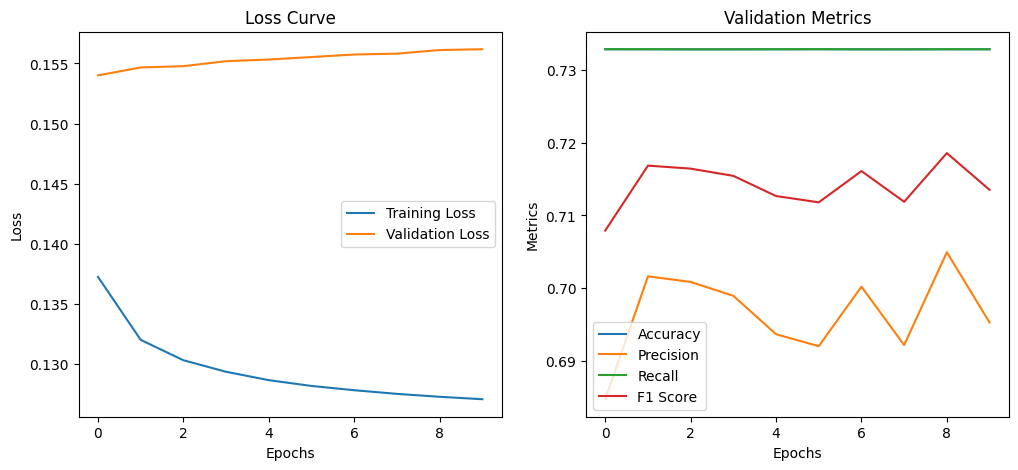

In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os

# 设定设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 假设你已经定义了 QADataset，并实例化了 tokenizer
train_dataset = QADataset('./data/SQuAD1.1/train.json', tokenizer, max_source_length=128, max_target_length=32)
dev_dataset = QADataset('./data/SQuAD1.1/dev.json', tokenizer, max_source_length=128, max_target_length=32)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)

# 假设你的模型是 Qwen2ForCausalLM，并且已经定义

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss(ignore_index=-100)  # 忽略填充部分
optimizer = optim.Adam(model.parameters(), lr=5e-5)

# 用于记录损失、准确率等指标
train_losses = []
dev_losses = []
dev_accuracies = []
dev_precisions = []
dev_recalls = []
dev_f1_scores = []

# 初始化用于保存最优模型的变量
best_f1_score = 0.0
best_model_path = "./best_model.pth"

# 训练循环
for epoch in range(10):  # 训练10个epoch
    model.train()
    total_loss = 0

    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

    # 验证
    model.eval()
    total_dev_loss = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for batch in dev_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_dev_loss += loss.item()

            predictions = torch.argmax(outputs.logits, dim=-1)
            all_labels.extend(labels.view(-1).tolist())
            all_predictions.extend(predictions.view(-1).tolist())

    avg_dev_loss = total_dev_loss / len(dev_loader)
    dev_losses.append(avg_dev_loss)

    # 计算多个评价指标
    dev_accuracy = accuracy_score(all_labels, all_predictions)
    dev_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
    dev_recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
    dev_f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

    dev_accuracies.append(dev_accuracy)
    dev_precisions.append(dev_precision)
    dev_recalls.append(dev_recall)
    dev_f1_scores.append(dev_f1)

    print(f"Epoch {epoch + 1}, Validation Loss: {avg_dev_loss}, Accuracy: {dev_accuracy}, Precision: {dev_precision}, Recall: {dev_recall}, F1 Score: {dev_f1}")

    # 保存最优模型
    if dev_f1 > best_f1_score:
        best_f1_score = dev_f1
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at epoch {epoch + 1}")

    # 每5轮保存一次模型
    if (epoch + 1) % 5 == 0:
        torch.save(model.state_dict(), f"./model_epoch_{epoch + 1}.pth")
        print(f"Model saved at epoch {epoch + 1}")

# 可视化损失和准确率
plt.figure(figsize=(12, 5))

# 训练和验证损失
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(dev_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

# 验证准确率和其他指标
plt.subplot(1, 2, 2)
plt.plot(dev_accuracies, label='Accuracy')
plt.plot(dev_precisions, label='Precision')
plt.plot(dev_recalls, label='Recall')
plt.plot(dev_f1_scores, label='F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.title('Validation Metrics')

# 保存图像
plt.savefig("./training_metrics.png")
plt.show()


In [ ]:
    # 验证模型
    model.eval()  # 设置模型为评估模式
    total_dev_loss = 0  # 记录验证损失
    all_labels = []  # 用于记录所有标签
    all_predictions = []  # 用于记录所有预测结果

    with torch.no_grad():  # 不需要计算梯度
        for batch in dev_loader:  # 遍历验证集
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # 前向传播
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss  # 计算损失
            total_dev_loss += loss.item()  # 累加损失

            # 获取预测结果
            predictions = torch.argmax(outputs.logits, dim=-1)
            all_labels.extend(labels.view(-1).tolist())  # 将标签展平并添加到列表中
            all_predictions.extend(predictions.view(-1).tolist())  # 将预测结果展平并添加到列表中

    avg_dev_loss = total_dev_loss / len(dev_loader)  # 计算平均验证损失
    dev_losses.append(avg_dev_loss)  # 记录验证损失
    dev_accuracy = accuracy_score(all_labels, all_predictions)  # 计算验证准确率
    dev_accuracies.append(dev_accuracy)  # 记录验证准确率

    print(f"Epoch {epoch + 1}, Validation Loss: {avg_dev_loss:.4f}, Validation Accuracy: {dev_accuracy:.4f}")


In [28]:
# 保存训练好的模型参数到文件中
torch.save(model.state_dict(), "qwen_model_finetuned.pth")  # 你可以更改路径或文件名


In [29]:
# 将模型设置为评估模式
model.eval()

# 输入一个问题和上下文
question = "What is in front of the Notre Dame Main Building?"
context = "Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend 'Venite Ad Me Omnes'."

# 使用 tokenizer 对输入进行编码
inputs = tokenizer.encode_plus(question, context, return_tensors="pt").to(device)

# 进行推理
with torch.no_grad():
    outputs = model.generate(inputs["input_ids"], max_length=64)

# 解码输出
answer = tokenizer.decode(outputs[0], skip_special_tokens=True)
print(f"Answer: {answer}")


The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Answer: What is in front of the Notre Dame Main Building?Immediately in front of the Main Building and facing it, is a copper statue of Christ with arms upraised with the legend 'Venite Ad Me Omnes'.


In [ ]:
from torch.optim import AdamW
from tqdm import tqdm
from transformers import DataCollatorWithPadding, AutoTokenizer

# 先加载模型的tokenizer
tokenizer = AutoTokenizer.from_pretrained("./model/qwen0.5b")

# 使用 DataCollatorWithPadding 来自动填充样本，使它们的长度一致

# 使用 DataCollatorWithPadding 来自动填充样本，使它们的长度一致
data_collator = DataCollatorWithPadding(tokenizer, return_tensors="pt")

# 创建 DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=data_collator)

# 定义优化器
optimizer = AdamW(model.parameters(), lr=5e-5)

# 训练函数
def train_epoch(model, dataloader, optimizer):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # 前向传播
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    
    return total_loss / len(dataloader)

# 训练示例
for epoch in range(1):  # 假设训练3个epoch
    avg_loss = train_epoch(model, dataloader, optimizer)
    print(f"Epoch {epoch+1}, Average Loss: {avg_loss}")


Epoch 1, Training Loss: 0.15772718668073443
Epoch 1, Validation Loss: 0.16952958052693787, Accuracy: 0.7328416062465142, Precision: 0.6492356667070133, Recall: 0.7328416062465142, F1 Score: 0.6884748149247966
Best model saved at epoch 1
Epoch 2, Training Loss: 0.1386456248310024
Epoch 2, Validation Loss: 0.16959130287130533, Accuracy: 0.7329210819854992, Precision: 0.6604150950960797, Recall: 0.7329210819854992, F1 Score: 0.694733422349549
Best model saved at epoch 2
Epoch 3, Training Loss: 0.12759576426476707
Epoch 3, Validation Loss: 0.17161292703049616, Accuracy: 0.732893195761294, Precision: 0.6651266026228124, Recall: 0.732893195761294, F1 Score: 0.6973198303411831
Best model saved at epoch 3
Epoch 4, Training Loss: 0.12032901837747623
Epoch 4, Validation Loss: 0.17373254747993175, Accuracy: 0.7328416062465142, Precision: 0.6660340900578695, Recall: 0.7328416062465142, F1 Score: 0.6978054633775691
Best model saved at epoch 4
Epoch 5, Training Loss: 0.11478301467286253
Epoch 5, Val

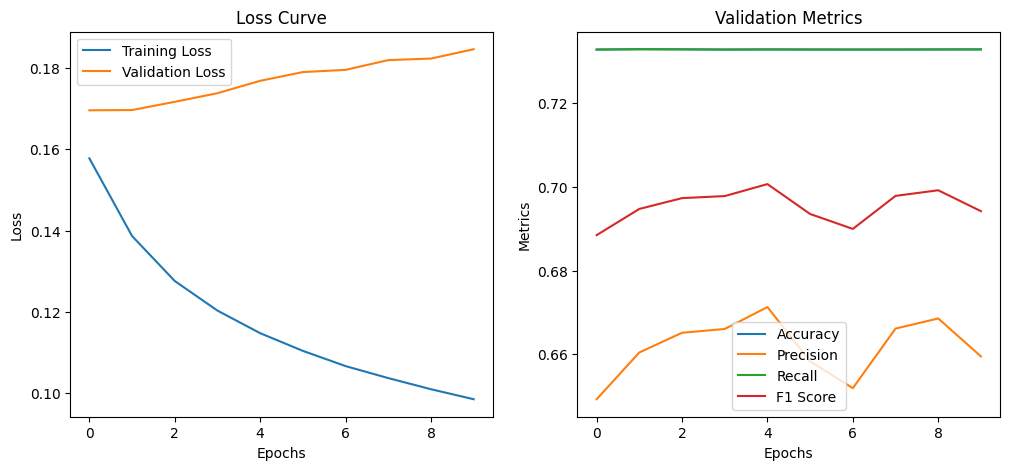

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os

# 定义训练函数，可以设置超参数
def train_model(model, train_dataset, dev_dataset, tokenizer, epochs=10, batch_size=8, learning_rate=5e-5, 
                save_interval=5, save_best_path="./best_model.pth", plot_path="./training_metrics.png"):
    
    # 设定设备
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # 创建数据加载器
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size, shuffle=False)

    # 定义损失函数和优化器
    criterion = nn.CrossEntropyLoss(ignore_index=-100)  # 忽略填充部分
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 用于记录损失、准确率等指标
    train_losses = []
    dev_losses = []
    dev_accuracies = []
    dev_precisions = []
    dev_recalls = []
    dev_f1_scores = []

    # 初始化用于保存最优模型的变量
    best_f1_score = 0.0

    # 训练循环
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            optimizer.zero_grad()
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch + 1}, Training Loss: {avg_train_loss}")

        # 验证
        model.eval()
        total_dev_loss = 0
        all_labels = []
        all_predictions = []

        with torch.no_grad():
            for batch in dev_loader:
                input_ids = batch["input_ids"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["labels"].to(device)

                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_dev_loss += loss.item()

                predictions = torch.argmax(outputs.logits, dim=-1)
                all_labels.extend(labels.view(-1).tolist())
                all_predictions.extend(predictions.view(-1).tolist())

        avg_dev_loss = total_dev_loss / len(dev_loader)
        dev_losses.append(avg_dev_loss)

        # 计算多个评价指标
        dev_accuracy = accuracy_score(all_labels, all_predictions)
        dev_precision = precision_score(all_labels, all_predictions, average='weighted', zero_division=0)
        dev_recall = recall_score(all_labels, all_predictions, average='weighted', zero_division=0)
        dev_f1 = f1_score(all_labels, all_predictions, average='weighted', zero_division=0)

        dev_accuracies.append(dev_accuracy)
        dev_precisions.append(dev_precision)
        dev_recalls.append(dev_recall)
        dev_f1_scores.append(dev_f1)

        print(f"Epoch {epoch + 1}, Validation Loss: {avg_dev_loss}, Accuracy: {dev_accuracy}, Precision: {dev_precision}, Recall: {dev_recall}, F1 Score: {dev_f1}")

        # 保存最优模型
        if dev_f1 > best_f1_score:
            best_f1_score = dev_f1
            torch.save(model.state_dict(), save_best_path)
            print(f"Best model saved at epoch {epoch + 1}")

        # 每save_interval轮保存一次模型
        if (epoch + 1) % save_interval == 0:
            torch.save(model.state_dict(), f"./model_epoch_{epoch + 1}.pth")
            print(f"Model saved at epoch {epoch + 1}")

    # 可视化损失和准确率
    plt.figure(figsize=(12, 5))

    # 训练和验证损失
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.plot(dev_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    # 验证准确率和其他指标
    plt.subplot(1, 2, 2)
    plt.plot(dev_accuracies, label='Accuracy')
    plt.plot(dev_precisions, label='Precision')
    plt.plot(dev_recalls, label='Recall')
    plt.plot(dev_f1_scores, label='F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('Metrics')
    plt.legend()
    plt.title('Validation Metrics')

    # 保存图像
    plt.savefig(plot_path)
    plt.show()


# 调用训练函数并设置参数
train_model(
    model=model, 
    train_dataset=train_dataset, 
    dev_dataset=dev_dataset, 
    tokenizer=tokenizer, 
    epochs=10, 
    batch_size=8, 
    learning_rate=5e-4, 
    save_interval=5, 
    save_best_path="./2best_model.pth", 
    plot_path="./2training_metrics.png"
)
